In [2]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform" 
# This makes JAX allocate exactly what is needed on demand, and deallocate memory that is no longer needed (note that this is the only configuration that will deallocate GPU memory, instead of reusing it). This is very slow, so is not recommended for general use, but may be useful for running with the minimal possible GPU memory footprint or debugging OOM failures.

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

from proba_sandbox.module_sandbox.dataset.tabular import TabularLoader
from proba_sandbox.module_sandbox.dataset.base import DataConfig

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from src.jax_test_model import MLPModel
from src.jax_test_model import MLPModel, init_t_lambda_to_phi, init_model_tube, init_model_phi
from numpyro.infer.util import initialize_model
from jax_tqdm import scan_tqdm
import blackjax
from numpyro.diagnostics import hpdi

%load_ext autoreload
%autoreload 2

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
#                            '--xla_dump_to=xla_dump/')
%env XLA_FLAGS

#jax.devices("gpu")

'--xla_force_host_platform_device_count=10'

In [6]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


In [6]:
config = {
    'curve_params': {'k': 10,
                     'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'elu'},
                     'n_samples': 500,
                     'lr': 0.01,
                     'num_epochs': 10_000,
                     #  'weight_decay': 0.0,
                     'use_validation': True,
                     'out_scale': 0.05,
                     'optimize_distparams': False
                     },
    'rng_seed': 14
}

### load results from wandb

In [45]:
def get_run(s_sampling, activation, k, seed):
    api = wandb.Api()
    for s_id in ['u7vfztsz',]:
        t_bar = tqdm(api.sweep(f"my_name/subspace_toy_reg/{s_id}").runs)
        t_bar.set_description(f"Sweep id: {s_id}")
        for run in t_bar:
            if ((run.config['curve_params']['model_kwargs']["activation"] == activation) and \
                (run.config["curve_params"]['k'] == k) and \
                (run.config["curve_params"]['uniform_t_optimize'] == s_sampling) and \
                (run.config["rng_seed"] == seed)):
                print(f"run found id: {run.id}")
                return run


# run = get_run("airfoil", "relu", k=10, seed=0, temp=1.)
run = get_run(s_sampling=True, activation="elu", k=20, seed=16)
run.config

Sweep id: u7vfztsz:   9%|▉         | 18/200 [00:00<00:00, 1000.19it/s]

run found id: b46ezdny


{'dataset': 'generate',
 'rng_seed': 16,
 'curve_params': {'k': 20,
  'lr': 0.001,
  'n_samples': 20,
  'out_scale': 0.05,
  'num_epochs': 100000,
  'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'elu'},
  'use_validation': True,
  'uniform_t_optimize': True,
  'optimize_distparams': True}}

Data shapes: (70, 1) (70,) (18, 1) (18,) (33, 1) (33,)


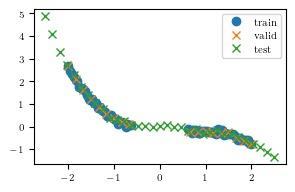

In [46]:
from src.utils import get_data, get_cp_w

x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=True)

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'x', label='valid')
plt.plot(x_test, y_test, 'x', label='test')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_val.shape,
      y_val.shape, x_test.shape, y_test.shape)

In [47]:
params = get_cp_w(run, from_path_optim_sweep=True, last=False)


model = MLPModel(**run.config['curve_params']['model_kwargs'])
s_model = SubspaceModel(model, 
                        k=run.config['curve_params']['k'],
                        n_samples=run.config['curve_params']['n_samples'],
                        out_scale=run.config['curve_params']['out_scale'],
                        optimize_distparams=run.config['curve_params']['optimize_distparams'],)

params

{'dist_params': {'log_scale': Array(-3.1901882, dtype=float32, weak_type=True)},
 'params': {'Dense_0': {'bias': Array([[-0.18926837, -0.27136576,  0.04296524, -1.6042161 , -0.2530895 ,
            1.537128  ,  0.07660983,  0.8119152 ,  0.7983319 , -0.5476047 ,
           -0.24519926, -0.22761896, -2.034944  , -0.34455857,  1.867906  ,
           -0.4609718 ],
          [-0.47223893, -0.39439544, -0.32688037, -1.5929621 , -0.44323668,
            1.5455858 ,  0.6418374 ,  1.6109971 ,  0.29585937, -0.5839625 ,
           -0.61178964, -0.41210112, -1.7189451 , -0.6101951 ,  1.8063561 ,
           -0.5663441 ],
          [-0.49687123, -0.52823263, -0.22309127, -0.8942603 , -0.6497919 ,
            0.84007347,  0.8533227 ,  2.2217493 , -0.18996625, -0.38507742,
           -0.5052282 , -0.09375414, -1.0139098 , -0.43097046,  1.2418642 ,
           -0.75569904],
          [-0.39584014, -0.3912122 , -0.20081222, -0.5759428 , -0.3566152 ,
            0.38991258,  0.763563  ,  2.3954644 , -0.26

(1000, 500)


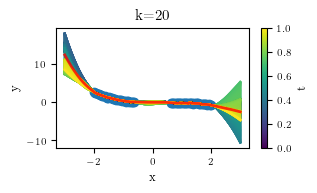

In [48]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
print(out.shape)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

#### compute functional differcity for different settings

In [49]:
def get_mean_out(run, x_lin, t_space):
    params = get_cp_w(run, from_path_optim_sweep=True, last=False)
    model = MLPModel(**run.config['curve_params']['model_kwargs'])
    s_model = SubspaceModel(model, 
                            k=run.config['curve_params']['k'],
                            n_samples=run.config['curve_params']['n_samples'],
                            out_scale=run.config['curve_params']['out_scale'],
                            optimize_distparams=run.config['curve_params']['optimize_distparams'],)
    out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
    return out

Sweep id: u7vfztsz:   9%|▉         | 18/200 [00:00<00:00, 1015.41it/s]

run found id: b46ezdny


Sweep id: u7vfztsz:   2%|▎         | 5/200 [00:00<00:00, 12610.66it/s]


run found id: zyyie2nr


Sweep id: u7vfztsz:  89%|████████▉ | 178/200 [00:00<00:00, 628.25it/s]


run found id: dc1v915b


Sweep id: u7vfztsz:  84%|████████▍ | 168/200 [00:00<00:00, 610.91it/s]


run found id: 21qt8cra


/tmp/ipykernel_3606684/399319289.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


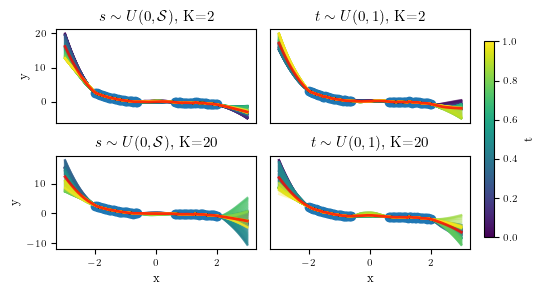

In [71]:
x_lin = jnp.linspace(-3, 3, 500)[:, None]
t_space = jnp.linspace(0, 1, 200)

run = get_run(s_sampling=True, activation="elu", k=20, seed=16)
out_true_20 = get_mean_out(run, x_lin, t_space)

run = get_run(s_sampling=False, activation="elu", k=20, seed=16)
out_flase_20 = get_mean_out(run, x_lin, t_space)

run = get_run(s_sampling=True, activation="elu", k=2, seed=16)
out_true_2 = get_mean_out(run, x_lin, t_space)

run = get_run(s_sampling=False, activation="elu", k=2, seed=16)
out_flase_2 = get_mean_out(run, x_lin, t_space)
x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=True)


fig, axes = plt.subplots(2, 2, figsize=(figsize[0]*1.5, figsize[1]*1.5))

for ax, out, title in zip(axes.flatten(), [out_true_2, out_flase_2, out_true_20, out_flase_20], [r'$s \sim U(0, \mathcal{S})$, K=2', r'$t \sim U(0, 1)$, K=2', r'$s \sim U(0, \mathcal{S})$, K=20', r'$t \sim U(0, 1)$, K=20']):
    ax.plot(x, y, 'o', label='train')
    colors = plt.cm.viridis(t_space)
    for o, c in zip(out, colors):
        ax.plot(x_lin, o, color=c, alpha=0.3)
    ax.plot(x_lin, out.mean(axis=0), label='mean',
            c='red', linewidth=2, alpha=0.8)
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_title(title)

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[1, 1].get_yaxis().set_visible(False)

# add colorbar
# Create a single colorbar outside the subplot
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar_ax = fig.add_axes([1.0, 0.2, 0.02, 0.65])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('t')

plt.tight_layout()
# plt.savefig("figures/functional_diversity_comparision.pdf",
#             bbox_inches='tight')

/tmp/ipykernel_3606684/3595830102.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


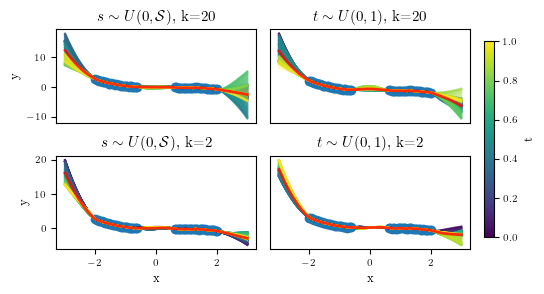

In [69]:

fig, axes = plt.subplots(2, 2, figsize=(figsize[0]*1.5, figsize[1]*1.5))

for ax, out, title in zip(axes.flatten(), [out_true_20, out_flase_20, out_true_2, out_flase_2], [r'$s \sim U(0, \mathcal{S})$, k=20', r'$t \sim U(0, 1)$, k=20', r'$s \sim U(0, \mathcal{S})$, k=2', r'$t \sim U(0, 1)$, k=2']):
    ax.plot(x, y, 'o', label='train')
    colors = plt.cm.viridis(t_space)
    for o, c in zip(out, colors):
        ax.plot(x_lin, o, color=c, alpha=0.3)
    ax.plot(x_lin, out.mean(axis=0), label='mean',
            c='red', linewidth=2, alpha=0.8)
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_title(title)

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[1, 1].get_yaxis().set_visible(False)

# add colorbar
# Create a single colorbar outside the subplot
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar_ax = fig.add_axes([1.0, 0.2, 0.02, 0.65])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('t')

plt.tight_layout()
plt.savefig("figures/functional_diversity_comparision.pdf", bbox_inches='tight')

## Run new experiment without wandb

### Display all data

In [9]:
config = {
    'curve_params': {'k': 10,
                     'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'elu'},
                     'n_samples': 500,
                     'lr': 0.01,
                     'num_epochs': 10_000,
                     #  'weight_decay': 0.0,
                     'use_validation': True,
                     'out_scale': 0.05,
                     'optimize_distparams': False
                     },
}

Data shapes: (70, 1) (70,) (18, 1) (18,) (33, 1) (33,)


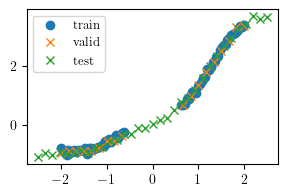

In [10]:
# Generate data by using the model itself
def gen_data(rng_seed, curve_params, **kwargs):
    rng_key = random.PRNGKey(rng_seed + 1133)
    x = jnp.linspace(-2, 2, 100)
    x = x[(jnp.abs(x) > 0.6)].reshape(-1, 1)

    # define ground trouth model
    rng_key, rng_init = random.split(rng_key)
    model_gen = MLPModel(**curve_params['model_kwargs'])
    params = model_gen.init(rng_init, x)

    # generate train data
    y_gt = model_gen.apply(params, x).squeeze()
    rng_key, rng = random.split(rng_key)
    y = y_gt + jax.random.normal(rng, y_gt.shape) * 0.05

    # generate valid data
    x_val = jnp.linspace(-2, 2, 25)
    x_val = x_val[(jnp.abs(x_val) > 0.6)].reshape(-1, 1)
    y_gt_val = model_gen.apply(params, x_val).squeeze()
    rng_key, rng = random.split(rng_key)
    y_val = y_gt_val + jax.random.normal(rng, y_gt_val.shape) * 0.05

    xt = jnp.linspace(-2.5, 2.5, 33).reshape(-1, 1)
    rng_key, rng = random.split(rng_key)
    y_gtt = model_gen.apply(params, xt).squeeze()
    yt = y_gtt + jax.random.normal(rng, y_gtt.shape) * 0.05

    return x, y, x_val, y_val, xt, yt, y_gtt


x, y, x_val, y_val, x_test, y_test,_ = gen_data(**config, rng_seed=14)

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'x', label='valid')
plt.plot(x_test, y_test, 'x', label='test')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_val.shape,
      y_val.shape, x_test.shape, y_test.shape)

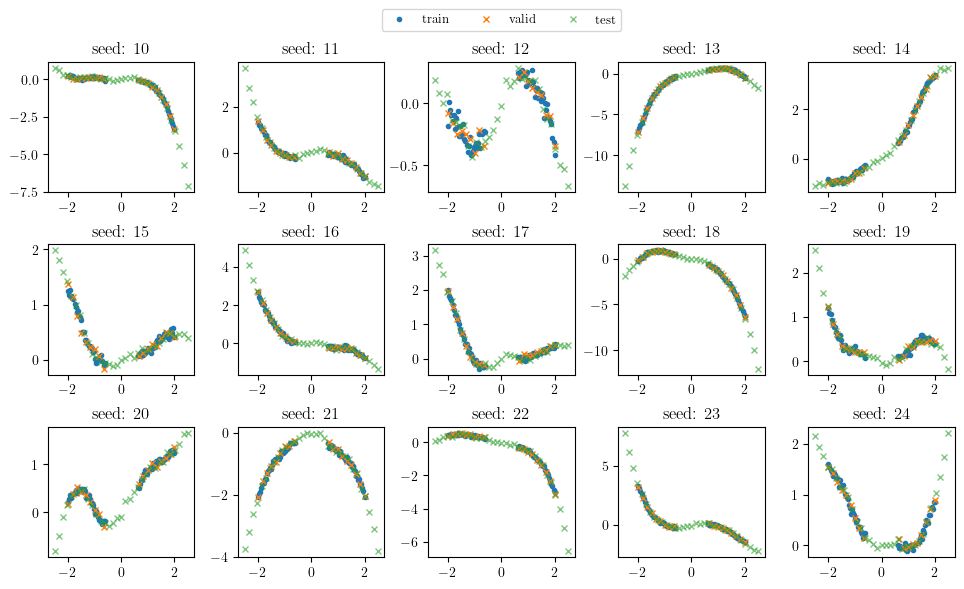

In [46]:
fig, axes = plt.subplots(3, 5, figsize=(figsize[0]*3, figsize[1]*3))
for rng_seed, ax in zip(range(10,25), axes.flatten()):
    x, y, x_val, y_val, x_test, y_test, y_gt = gen_data(**config, rng_seed=rng_seed)
    ax.plot(x, y, 'o', label='train', markersize=3)
    ax.plot(x_val, y_val, 'x', label='valid', markersize=5)
    ax.plot(x_test, y_test, 'x', label='test', markersize=5, alpha=0.6)
    ax.set_title(f"seed: {rng_seed}")
axes[0,2].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.45))
plt.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.4)


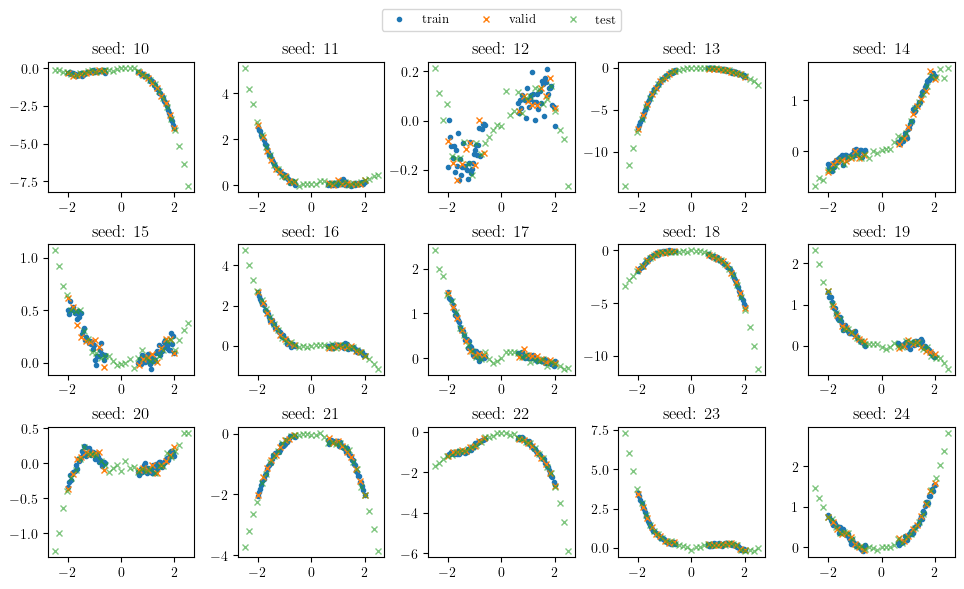

In [48]:
config = {
    'curve_params': {'k': 10,
                     'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'relu'},
                     'n_samples': 500,
                     'lr': 0.01,
                     'num_epochs': 10_000,
                     #  'weight_decay': 0.0,
                     'use_validation': True,
                     'out_scale': 0.05,
                     'optimize_distparams': False
                     },
}

fig, axes = plt.subplots(3, 5, figsize=(figsize[0]*3, figsize[1]*3))
for rng_seed, ax in zip(range(10, 25), axes.flatten()):
    x, y, x_val, y_val, x_test, y_test, y_gt = gen_data(
        **config, rng_seed=rng_seed)
    ax.plot(x, y, 'o', label='train', markersize=3)
    ax.plot(x_val, y_val, 'x', label='valid', markersize=5)
    ax.plot(x_test, y_test, 'x', label='test', markersize=5, alpha=0.6)
    ax.set_title(f"seed: {rng_seed}")
axes[0, 2].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.45))
plt.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("figures/data_generation_relu.pdf", bbox_inches='tight')

### load default data

Data shapes: (56, 1) (56,) (14, 1) (14,) (33, 1) (33,)


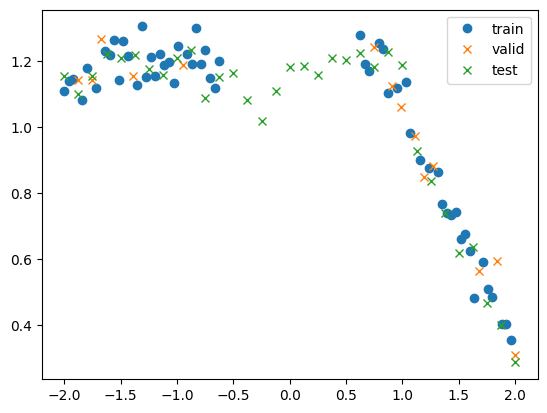

: 

In [54]:
# load data
def load_data():
    data = jnp.load('regression_data.npz')
    x = jnp.array(data['x'])
    y = jnp.array(data['y'])
    x_test = jnp.array(data['xt'])
    y_test = jnp.array(data['yt'])
    return x, y, x_test, y_test


x, y, x_test, y_test = load_data()
# draw valudation data from x
n = x.shape[0]
n_val = int(n * 0.2)
val_idx = jax.random.choice(random.PRNGKey(0), n, (n_val,), replace=False)
x_val = x[val_idx]
y_val = y[val_idx]
x = jnp.delete(x, val_idx, axis=0)
y = jnp.delete(y, val_idx, axis=0)


plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'x', label='valid')
plt.plot(x_test, y_test, 'x', label='test')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

### Define model structure

In [4]:
from src.jax_test_model import MLPModel
from src.jax_subspace_curve import bezier_coeff_fn



bezier_coeff_inv = bezier_coeff_fn(config['curve_params']['k'])
# bezier_coeff = bezier_coeff_fn(config['curve_params']['k'] + 1)

def get_d_bezier(t):
    coeff = jax.vmap(bezier_coeff_inv)(t)
    def clousure(cp):
        n = cp.shape[0] - 1
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('tj,j...->t...', coeff, cp_diff) * n
    return clousure

@jit
def bezier_length(cp):
    t = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(t)
    d_t = jnp.linalg.norm(d_bezier(cp), axis=-1)
    length = jax.scipy.integrate.trapezoid(d_t, t)
    return length

In [5]:
def train_curve(rng_key, k: int, model_kwargs: dict, n_samples: int, lr: float, num_epochs: int, out_scale,
                optimize_distparams, use_validation: bool = False):
    rng_key, init_key = random.split(rng_key)
    model = MLPModel(**model_kwargs)
    s_model = SubspaceModel(model, k,
                            n_samples=n_samples,
                            out_scale=out_scale,
                            optimize_distparams=optimize_distparams)
    params = s_model.init_params(init_key, x)

    # Train
    optimizer = optax.adam(lr)
    if optimize_distparams:
        # dnn_parameters + dist_parameters
        opt_state = optimizer.init(params)
    else:
        opt_state = optimizer.init(params['params'])  # only dnn parameters
    best_loss = np.inf
    best_params = params

    # define metric function.
    # if use_validation is True, use validation data to select best model parameters
    # else use training data but compute loss trough 1000 curve samples
    def comp_metric_set(x, y):
        return lambda subkey, params: s_model.compute_loss(
            subkey, params, x, y, n_samples=1000)
    if use_validation:
        comp_metric = comp_metric_set(x_val, y_val)
    else:
        comp_metric = comp_metric_set(x, y)

    # train loop
    @scan_tqdm(num_epochs)
    def train(carry, _):
        rng_key, params, opt_state, best_loss, best_params = carry
        rng_key, subkey = random.split(rng_key)
        loss, params, opt_state = s_model.train_step(
            subkey, params, x, y, opt_state, optimizer)
        # validate
        rng_key, subkey = random.split(rng_key)
        val_loss = comp_metric(subkey, params)
        best_params = jax.lax.cond(
            val_loss < best_loss, lambda x: params, lambda x: best_params, None)
        best_loss = jnp.minimum(best_loss, val_loss)
        return (rng_key, params, opt_state, best_loss, best_params), (loss, val_loss)
    carry = (rng_key, params, opt_state, best_loss, best_params)
    carry, (losses, valid_losses) = jax.lax.scan(train, carry,
                                                    jnp.arange(num_epochs))
    
    fig, ax = plt.subplots()
    ax.plot(losses, label='train')
    ax.plot(valid_losses, label='valid')
    # ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('nll')
    plt.ylim(losses.min(), -1.)

    # log losses for wandb
    params = carry[4]  # select best parameters
    rng_key = carry[0]

    return rng_key, params, model, s_model, (losses, valid_losses)

### Curve k=2

  0%|          | 0/10000 [00:00<?, ?it/s]

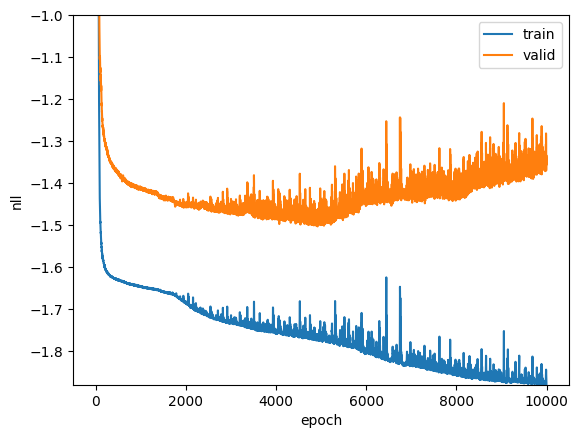

In [6]:
config['curve_params']['k'] = 2
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

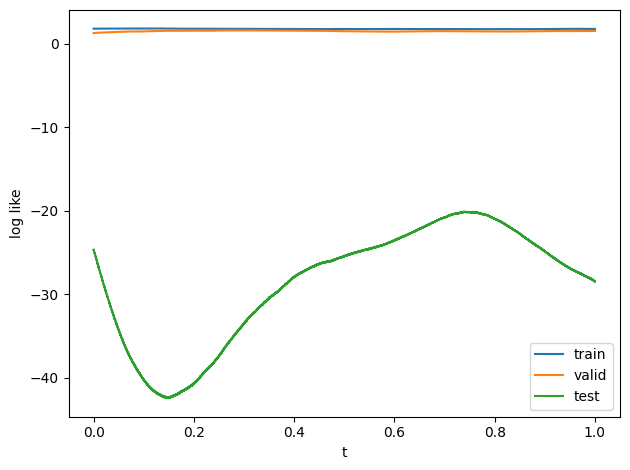

In [7]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

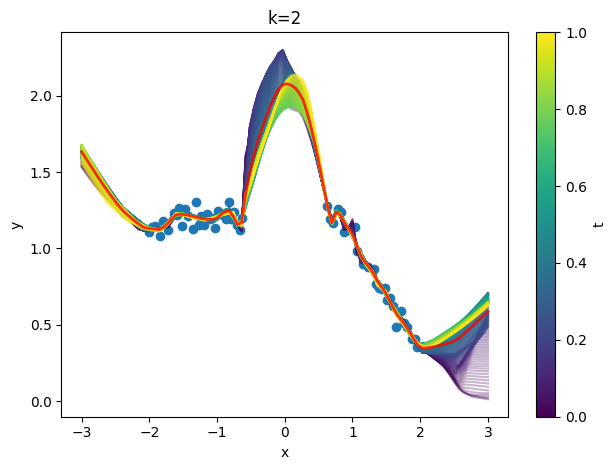

In [8]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

### Curve k=5

  0%|          | 0/10000 [00:00<?, ?it/s]

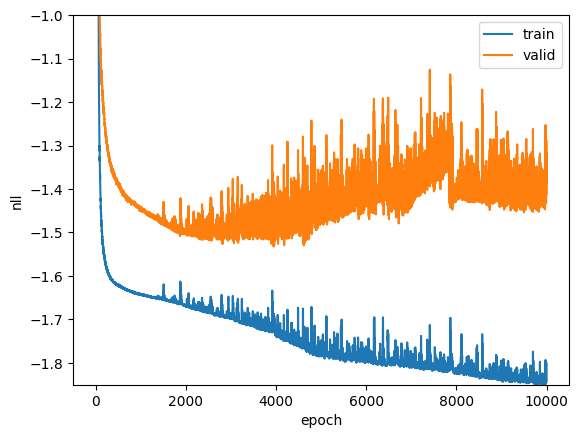

In [8]:
config['curve_params']['k'] = 5
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

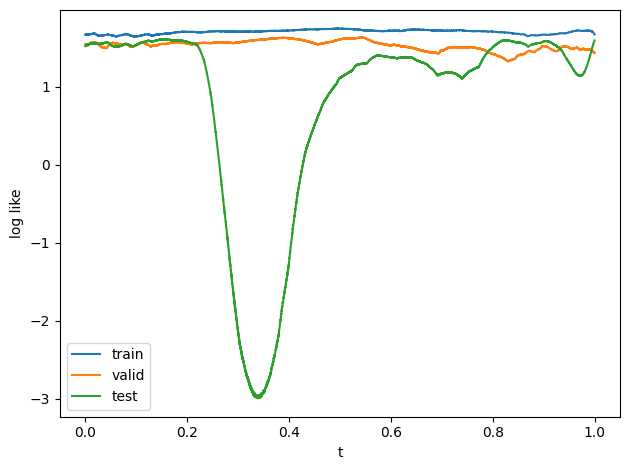

In [9]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

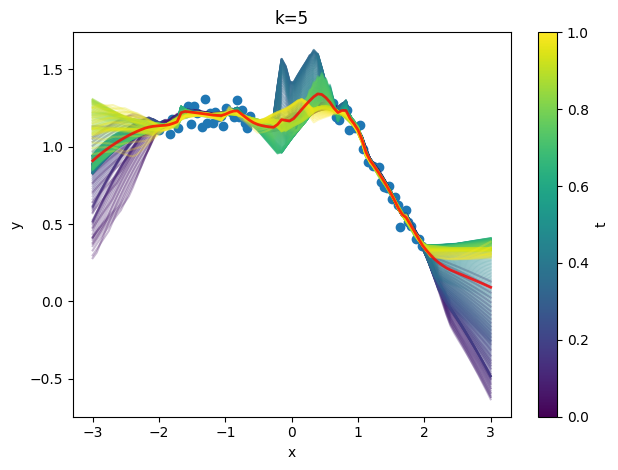

In [10]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

### Curve k=10

  0%|          | 0/10000 [00:00<?, ?it/s]

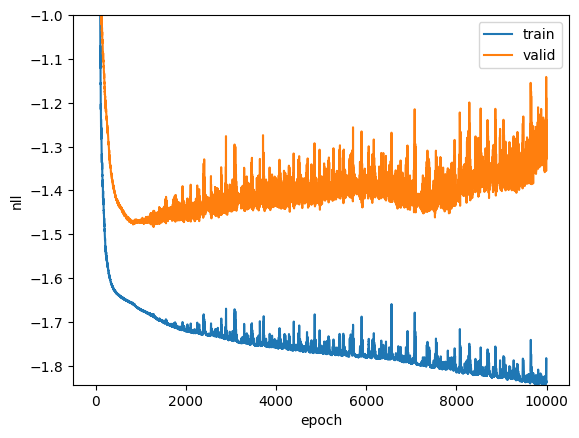

In [11]:
config['curve_params']['k'] = 10
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

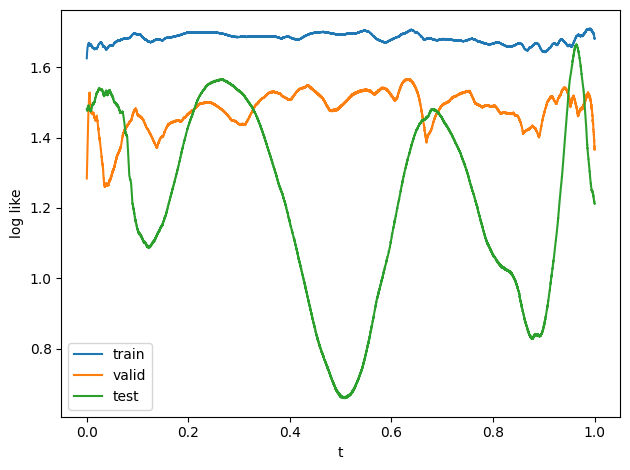

In [12]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

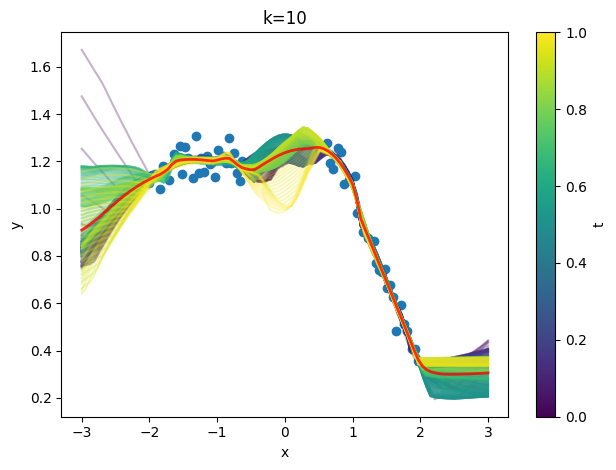

In [13]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

### Curve k=20

  0%|          | 0/10000 [00:00<?, ?it/s]

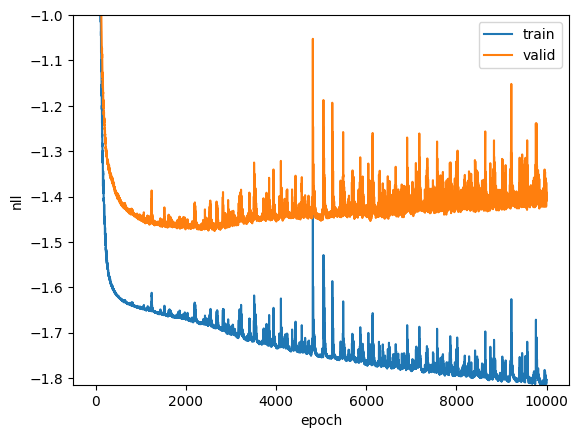

In [14]:
config['curve_params']['k'] = 20
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

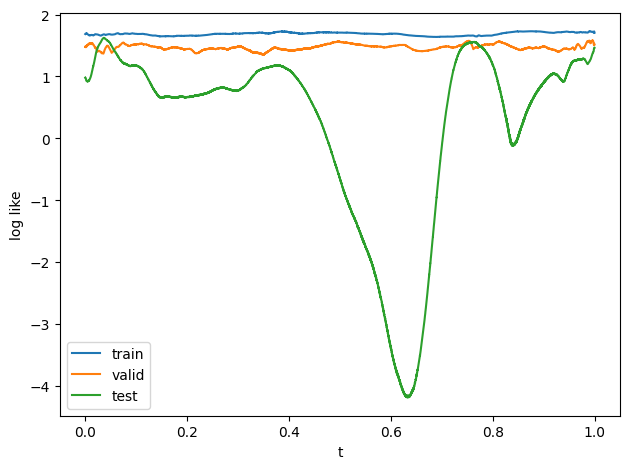

In [15]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

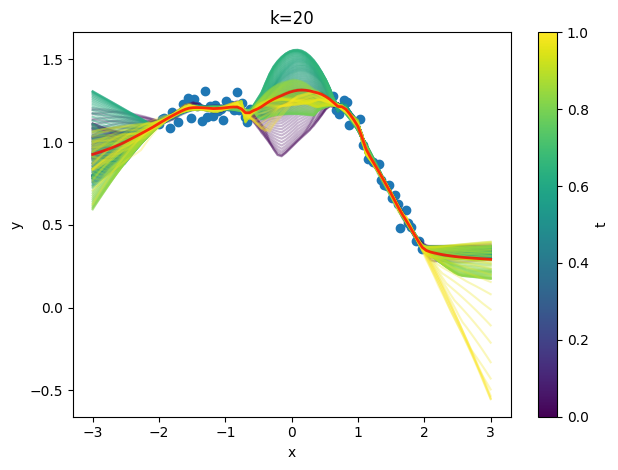

In [16]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

### Curve k=40

  0%|          | 0/10000 [00:00<?, ?it/s]

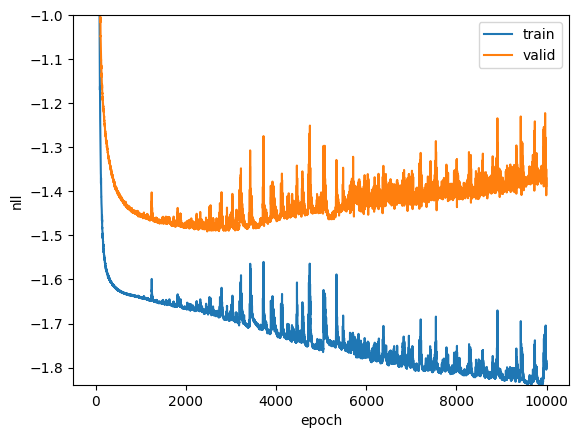

In [17]:
config['curve_params']['k'] = 40
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

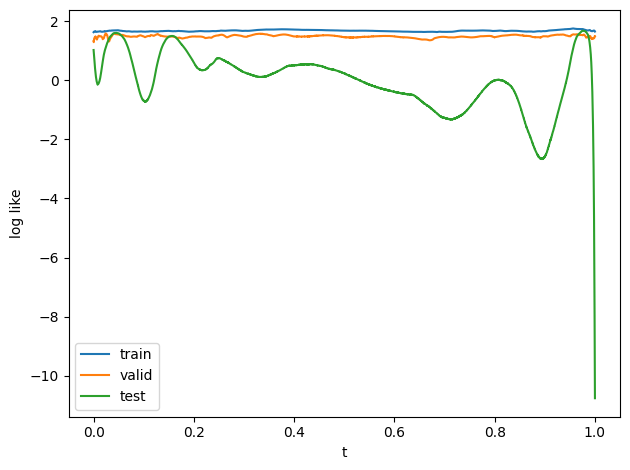

In [18]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

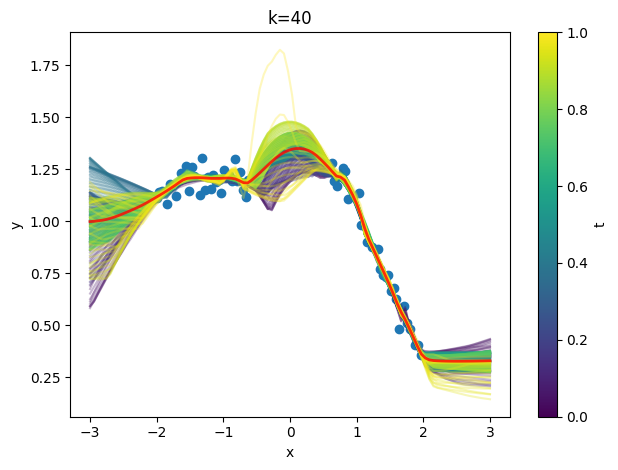

In [19]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

### Curve k=100

  0%|          | 0/10000 [00:00<?, ?it/s]

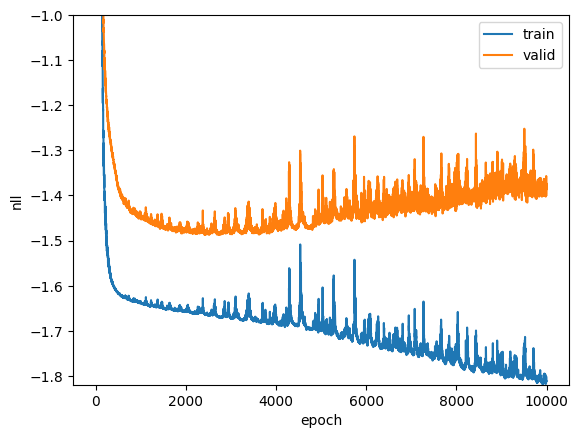

In [20]:
config['curve_params']['k'] = 100
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

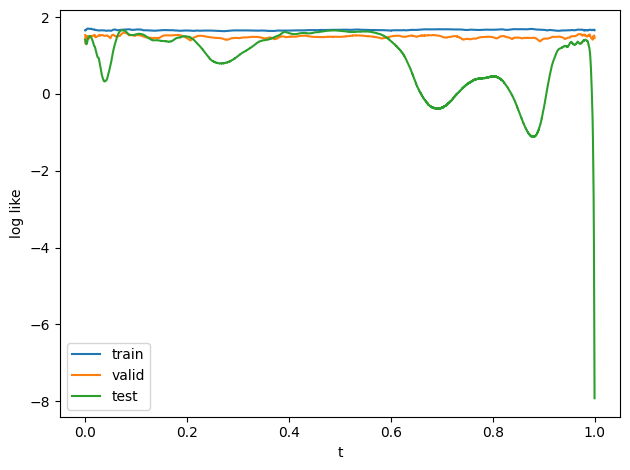

In [21]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

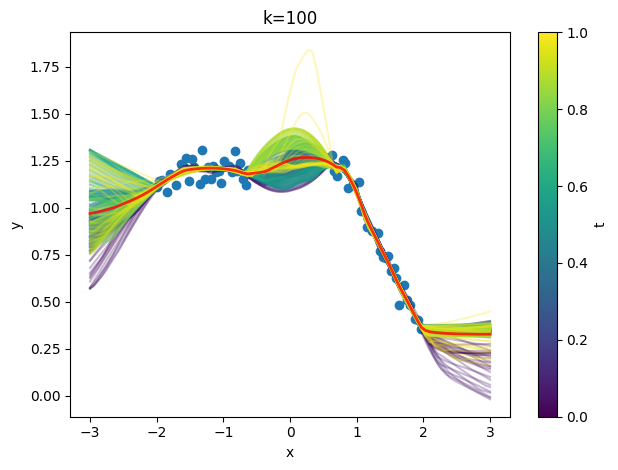

In [22]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()

### Curve k=120

  0%|          | 0/10000 [00:00<?, ?it/s]

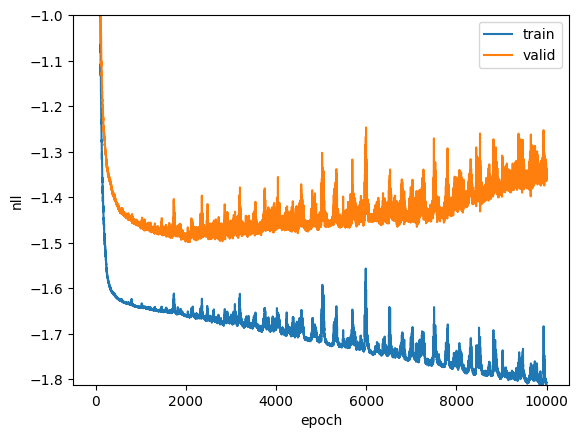

In [23]:
config['curve_params']['k'] = 120
rng_key, params, model,s_model, (losses, valid_losses) = train_curve(
    random.PRNGKey(0), **config['curve_params'])

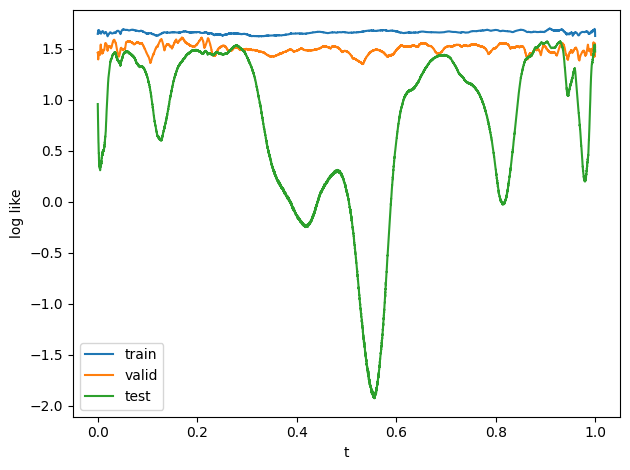

In [24]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 10_000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll, label='train')
# valdiation
ll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
ax.plot(t_space, ll, label='valid')
# test
ll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)
ax.plot(t_space, ll, label='test')

ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.legend()
plt.tight_layout()

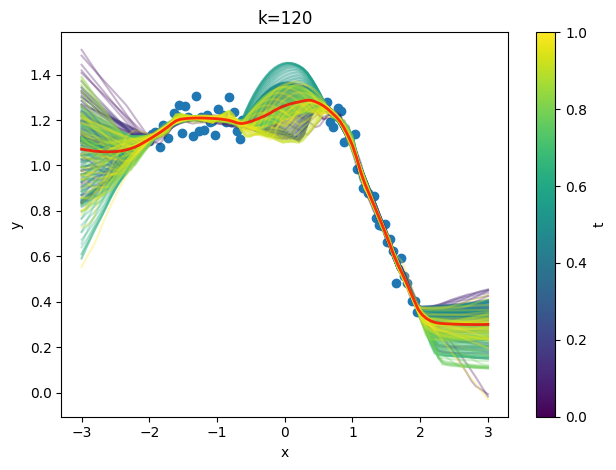

In [25]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 300)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={config['curve_params']['k']}")
plt.tight_layout()